In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [2]:
us_states = pd.read_csv("./us_states.csv")
state_latlong = pd.read_csv('./statelatlong.csv')
us_states.drop('fips', axis=1, inplace=True)

In [3]:
# inner join eliminates some of the datapoints from the df "us_states"
# No corresponding "state_latlongs" are available for these datapoints

merged_df = pd.merge(us_states, state_latlong, on='City', how='inner')
print("MERGED DATA:")
print("")
print(merged_df.head())

MERGED DATA:

         date      City  cases  deaths State   Latitude  Longitude
0  2020-01-24  Illinois      1       0    IL  39.739318 -89.504139
1  2020-01-25  Illinois      1       0    IL  39.739318 -89.504139
2  2020-01-26  Illinois      1       0    IL  39.739318 -89.504139
3  2020-01-27  Illinois      1       0    IL  39.739318 -89.504139
4  2020-01-28  Illinois      1       0    IL  39.739318 -89.504139


In [4]:
sampled_data = merged_df[merged_df['date'] == '2020-03-25']
print("SAMPLED DATA:")
print("")
print(sampled_data.head())

SAMPLED DATA:

           date           City  cases  deaths State   Latitude   Longitude
61   2020-03-25       Illinois   1875      21    IL  39.739318  -89.504139
134  2020-03-25     California   3183      67    CA  37.271875 -119.270415
206  2020-03-25        Arizona    402       6    AZ  34.168219 -111.930907
272  2020-03-25  Massachusetts   1838      15    MA  42.062940  -71.718067
334  2020-03-25      Wisconsin    623       7    WI  44.786297  -89.826705


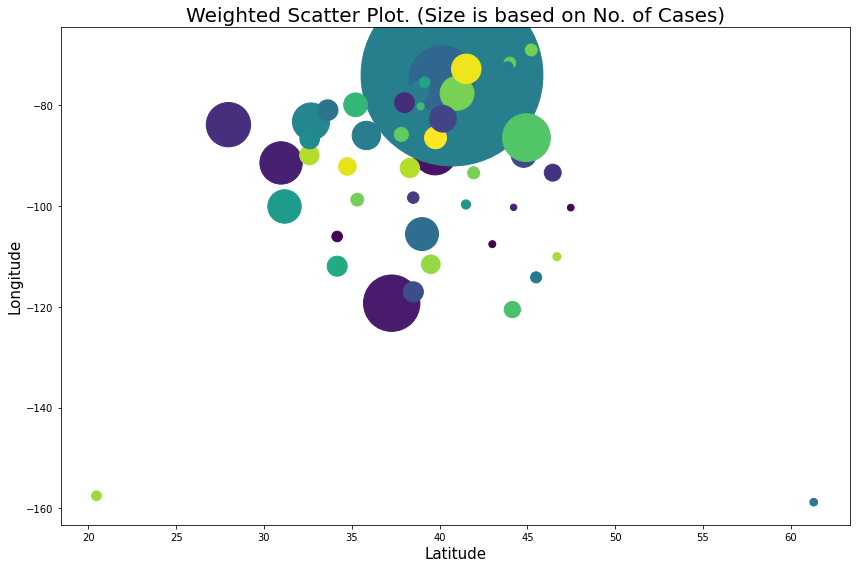

In [5]:
x_axis = sampled_data['Latitude']
y_axis = sampled_data['Longitude']
cases = sampled_data['cases']
colors = np.random.rand(sampled_data.shape[0])
# Figure:
plt.figure(1, figsize=(12, 8))
plt.title("Weighted Scatter Plot. (Size is based on No. of Cases)", fontsize=20)
# plt.get_cmap('viridis')
plt.scatter(x_axis, y_axis, s=cases, c=colors)
plt.xlabel("Latitude", fontsize=15)
plt.ylabel("Longitude", fontsize=15)
plt.tight_layout()
# plt.savefig("./scatter_plot_3_1_c.png")
plt.show()

In [6]:
# considering three columns from sampled data - [’Longitude’,’Latitude’, ’Cases’]
raw_X = sampled_data[['Longitude', 'Latitude', 'cases']]

In [7]:
def get_distortions(k_range, X, weight=False):
    # k means determine k
    distortions = []
    K = k_range
    for k in K:
        if weight:
            model = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(X[:, :-1], sample_weight=X[:, -1])
        else:
            model = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(X)
        model.fit(X)
        distortions.append(model.inertia_)
        #distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    return distortions

In [8]:
X = raw_X[['Longitude', 'Latitude']]
K = range(1, 51)
# get the loss-function values for all 50 values of k
inertia = get_distortions(K, X, weight=False)

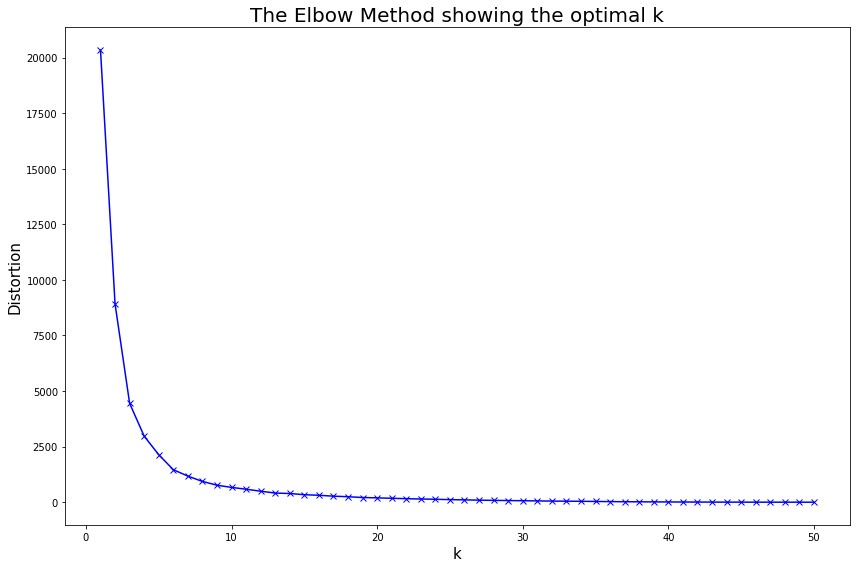

In [9]:
# Plot the elbow
plt.figure(2, figsize=(12, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Distortion', fontsize = 15)
plt.title('The Elbow Method showing the optimal k', fontsize = 20)
plt.tight_layout()
# plt.savefig("./plot_3_2_a.png")
plt.show()

#### We can see that elbow is at k = 8. 

### Unweighted K-means clustering by location for K = 15

In [10]:
K = 15
model = KMeans(n_clusters=K, init='k-means++', random_state=42)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

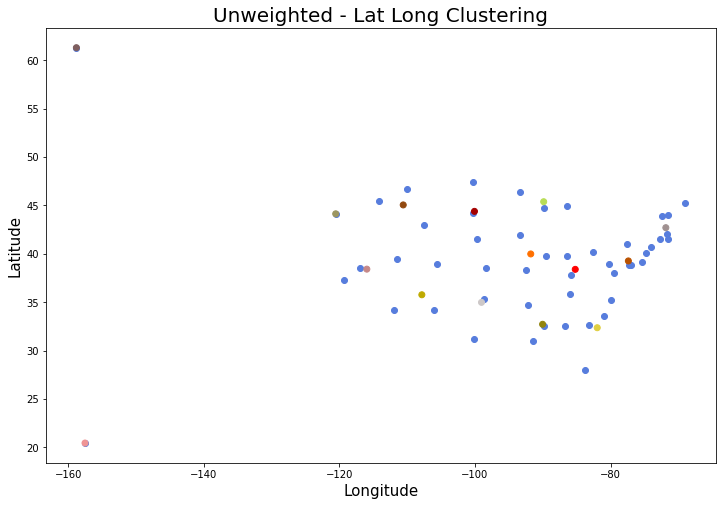

In [11]:
plt.figure(3, figsize=(12, 8))
plt.title("Unweighted - Lat Long Clustering", fontsize=20)
x_axis = X['Longitude']
y_axis = X['Latitude']
plt.scatter(x_axis, y_axis, c='#577DDD')

cluster_colors = ['#FF0000', '#A40000', '#F09494', '#C68888', '#7F5F5F', '#A09191', '#CDC8C8', '#FF7000', 
                  '#BA5200', '#92490F', '#92840F', '#BFAA00', '#E0CF41', '#9C9660', '#B9DD57']

plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c=cluster_colors)
plt.xlabel("Longitude", fontsize=15)
plt.ylabel("Latitude", fontsize=15)
# plt.savefig("./plot_3_2_b.png")
plt.show()

#### Blue Color represents the datapoints. Colored points are the 15 clusters. 

In [12]:
temp = sampled_data.copy()
temp['cluster_id'] = model.predict(sampled_data[['Longitude', 'Latitude']])
temp = temp[['State', 'cluster_id']]

In [13]:
for i in range(K):
    print("Cluster", i, set(temp[temp['cluster_id'] == i]['State'].values))

Cluster 0 {'TN', 'IN', 'OH', 'KY'}
Cluster 1 {'SD', 'ND', 'NE'}
Cluster 2 {'HI'}
Cluster 3 {'UT', 'CA', 'NV'}
Cluster 4 {'AK'}
Cluster 5 {'RI', 'VT', 'ME', 'MA', 'NY', 'CT', 'NH'}
Cluster 6 {'TX', 'OK', 'KS'}
Cluster 7 {'IA', 'MO', 'IL'}
Cluster 8 {'WV', 'DC', 'PA', 'DE', 'VA', 'NJ', 'MD'}
Cluster 9 {'WY', 'ID', 'MT'}
Cluster 10 {'MS', 'AR', 'AL', 'LA'}
Cluster 11 {'AZ', 'NM', 'CO'}
Cluster 12 {'FL', 'SC', 'NC', 'GA'}
Cluster 13 {'OR'}
Cluster 14 {'MN', 'MI', 'WI'}


### Weighted K-means by location

In [14]:
K = range(1, 51)
inertia = get_distortions(K, raw_X.values, weight=True)

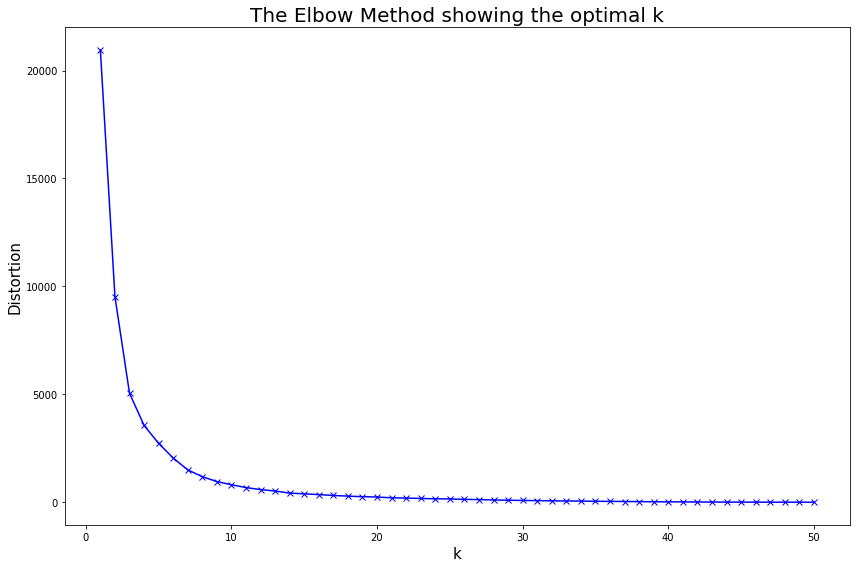

In [15]:
# Plot the elbow
plt.figure(4, figsize=(12, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Distortion', fontsize = 15)
plt.title('The Elbow Method showing the optimal k', fontsize = 20)
plt.tight_layout()
# plt.savefig("./plot_3_2_c.png")
plt.show()

### Weighted K-means by location

In [16]:
K = 15
model = KMeans(n_clusters=K, init='k-means++', random_state=42)
model.fit(raw_X[['Longitude', 'Latitude']], sample_weight=raw_X['cases'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

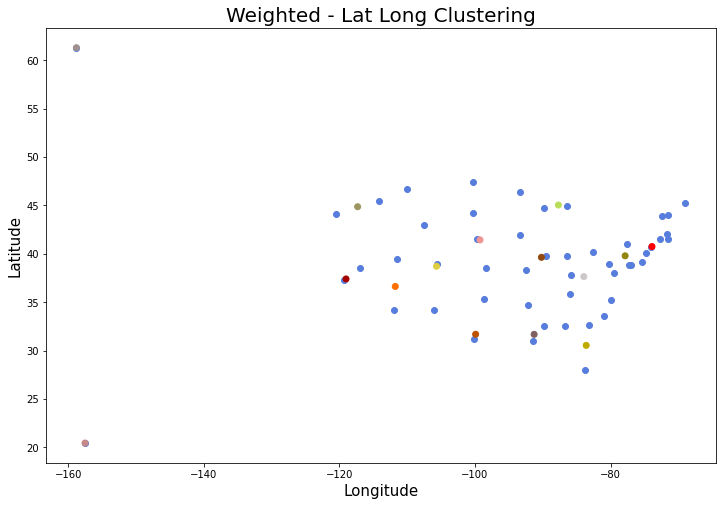

In [17]:
plt.figure(3, figsize=(12, 8))
plt.title("Weighted - Lat Long Clustering", fontsize=20)
x_axis = raw_X['Longitude']
y_axis = raw_X['Latitude']
plt.scatter(x_axis, y_axis, c='#577DDD')

cluster_colors = ['#FF0000', '#A40000', '#F09494', '#C68888', '#7F5F5F', '#A09191', '#CDC8C8', '#FF7000', 
                  '#BA5200', '#92490F', '#92840F', '#BFAA00', '#E0CF41', '#9C9660', '#B9DD57']

plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c=cluster_colors)
plt.xlabel("Longitude", fontsize=15)
plt.ylabel("Latitude", fontsize=15)
# plt.savefig("./plot_3_2_d.png")
plt.show()

In [18]:
temp = sampled_data.copy()
temp['cluster_id'] = model.predict(raw_X[['Longitude', 'Latitude']])
temp = temp[['State', 'cluster_id']]

for i in range(K):
    print("Cluster", i, set(temp[temp['cluster_id'] == i]['State'].values))

Cluster 0 {'RI', 'VT', 'DE', 'ME', 'NJ', 'MA', 'NY', 'CT', 'NH'}
Cluster 1 {'CA', 'NV'}
Cluster 2 {'KS', 'SD', 'ND', 'NE'}
Cluster 3 {'HI'}
Cluster 4 {'MS', 'AR', 'LA'}
Cluster 5 {'AK'}
Cluster 6 {'TN', 'OH', 'IN', 'NC', 'KY'}
Cluster 7 {'AZ', 'UT'}
Cluster 8 {'TX', 'OK'}
Cluster 9 {'IA', 'MO', 'IL'}
Cluster 10 {'WV', 'DC', 'PA', 'VA', 'MD'}
Cluster 11 {'FL', 'SC', 'AL', 'GA'}
Cluster 12 {'WY', 'NM', 'CO'}
Cluster 13 {'OR', 'ID', 'MT'}
Cluster 14 {'MN', 'MI', 'WI'}


### Growth Rate Modeling and Distribution Analysis 

In [19]:
growth_df = us_states.copy()
growth_df['date'] = pd.factorize(growth_df.date)[0]

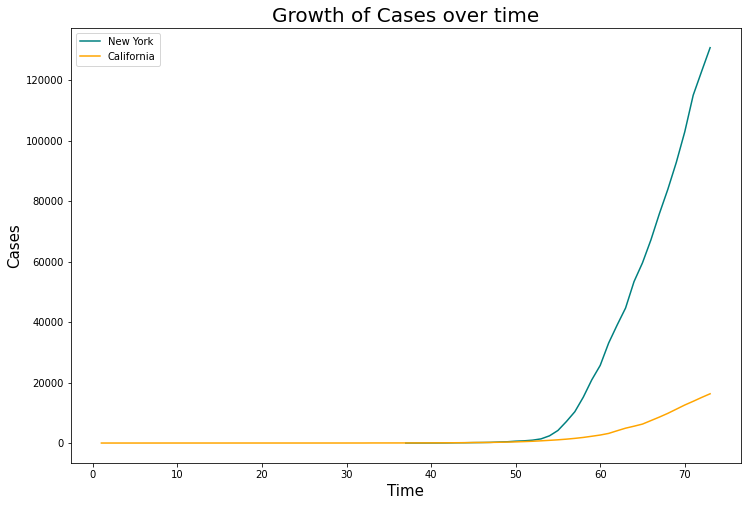

In [20]:
ny_df = growth_df[growth_df['City'] == 'New York']
cali_df = growth_df[growth_df['City'] == 'California']

plt.figure(4, figsize=(12, 8))
plt.title("Growth of Cases over time", fontsize=20)
x_axis = ny_df['date']
y_axis = ny_df['cases']
plt.plot(x_axis, y_axis, color='teal')

x2_axis = cali_df['date']
y2_axis = cali_df['cases']
plt.plot(x2_axis, y2_axis, color='orange')

plt.xlabel("Time", fontsize=15)
plt.ylabel("Cases", fontsize=15)
plt.legend(['New York', 'California'], loc="upper left")
# plt.savefig("./plot_3_3_a.png")
plt.show()

In [21]:
cities = growth_df['City'].unique()
state_wise_EM = pd.DataFrame(columns=['City', 'A', 'B'])

In [22]:
i = 0
for city in cities:
    data = growth_df[growth_df['City'] == city]
    city_X = data['date'].values
    city_y = data['cases'].values
    city_p = np.polyfit(city_X, np.log(city_y), 1)
    
    state_wise_EM.loc[i] = [city, np.exp(city_p[1]), city_p[0]]
    i+=1

In [23]:
print("State-wise A and B values:")
print(state_wise_EM)

State-wise A and B values:
                        City         A         B
0                   Illinois  0.153364  0.135352
1                 California  0.546584  0.134565
2                    Arizona  0.099981  0.117539
3              Massachusetts  0.021756  0.173563
4                  Wisconsin  0.017457  0.154513
5                      Texas  0.025346  0.170542
6                   Nebraska  0.828091  0.077562
7                       Utah  0.000286  0.222321
8                     Oregon  0.001340  0.196915
9                    Florida  0.000111  0.267648
10                  New York  0.000047  0.320191
11              Rhode Island  0.000735  0.197822
12                   Georgia  0.000128  0.258251
13             New Hampshire  0.000685  0.196140
14            North Carolina  0.000055  0.255646
15                New Jersey  0.000004  0.331837
16                  Colorado  0.000639  0.229981
17                  Maryland  0.000130  0.243858
18                    Nevada  0.000135  0.

In [24]:
cali_A = state_wise_EM[state_wise_EM['City'] == 'California']['A']
cali_B = state_wise_EM[state_wise_EM['City'] == 'California']['B']
cali_df['pred'] = cali_df.apply(lambda i: cali_A * np.exp(cali_B * i.date), axis=1)

ny_A = state_wise_EM[state_wise_EM['City'] == 'New York']['A']
ny_B = state_wise_EM[state_wise_EM['City'] == 'New York']['B']
ny_df['pred'] = ny_df.apply(lambda i: ny_A * np.exp(ny_B * i.date), axis=1)

C:\Users\nisha\.conda\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nisha\.conda\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


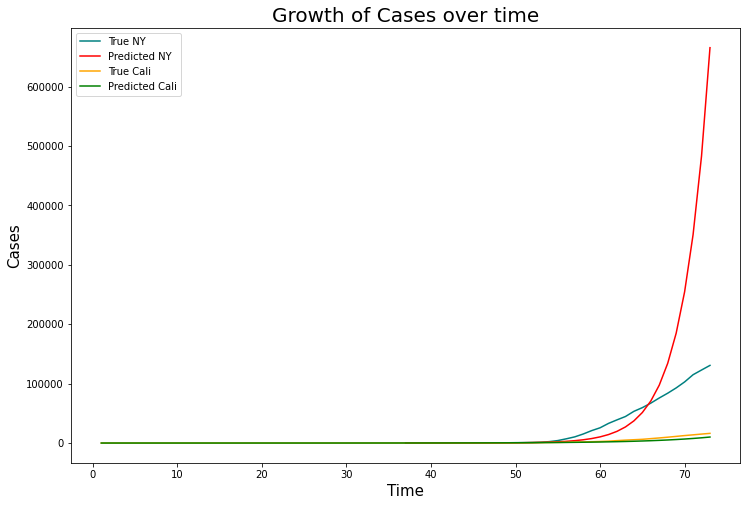

In [25]:
plt.figure(5, figsize=(12, 8))
plt.title("Growth of Cases over time", fontsize=20)
x_axis = ny_df['date']
plt.plot(x_axis, ny_df['cases'], color='teal')
plt.plot(x_axis, ny_df['pred'], color='red')

x2_axis = cali_df['date']
plt.plot(x2_axis, cali_df['cases'], color='orange')
plt.plot(x2_axis, cali_df['pred'], color='green')

plt.xlabel("Time", fontsize=15)
plt.ylabel("Cases", fontsize=15)
plt.legend(['True NY', 'Predicted NY', 'True Cali', 'Predicted Cali'], loc="upper left")
# plt.savefig("./plot_3_3_c.png")
plt.show()

### Unweighted K-means clustering by growth rate

In [26]:
X = state_wise_EM[['A', 'B']]
K = range(1, 51)
# get the loss-function values for all 50 values of k
inertia = get_distortions(K, X, weight=False)

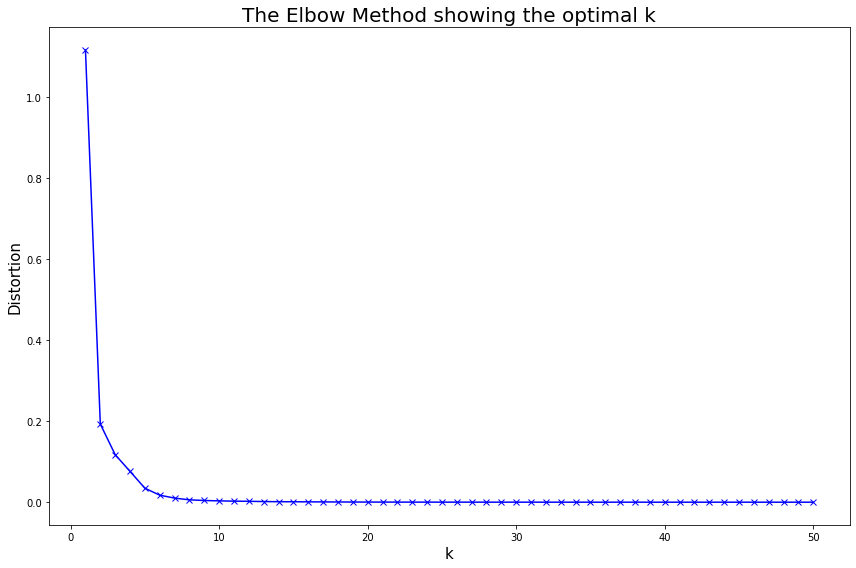

In [27]:
# Plot the elbow
plt.figure(6, figsize=(12, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Distortion', fontsize = 15)
plt.title('The Elbow Method showing the optimal k', fontsize = 20)
plt.tight_layout()
# plt.savefig("./plot_3_3_d.png")
plt.show()

#### Optimal value of k = 5

### 3.3 e - K-means clustering by Growth Rate

In [28]:
K = 8
model = KMeans(n_clusters=K, init='k-means++', random_state=42)
model.fit(state_wise_EM[['A', 'B']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

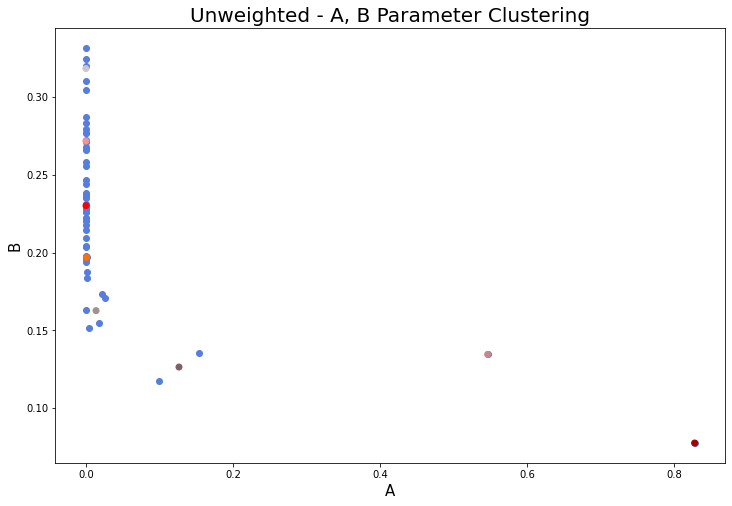

In [29]:
plt.figure(7, figsize=(12, 8))
plt.title("Unweighted - A, B Parameter Clustering", fontsize=20)
x_axis = state_wise_EM['A']
y_axis = state_wise_EM['B']
plt.scatter(x_axis, y_axis, c='#577DDD')

cluster_colors = ['#FF0000', '#A40000', '#F09494', '#C68888', '#7F5F5F', '#A09191', '#CDC8C8', '#FF7000']

plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c=cluster_colors)
plt.xlabel("A", fontsize=15)
plt.ylabel("B", fontsize=15)
# plt.savefig("./plot_3_3_e.png")
plt.show()

In [30]:
merged_df2 = pd.merge(state_wise_EM, state_latlong, on='City', how='inner')
temp = merged_df2.copy()
temp['cluster_id'] = model.predict(merged_df2[['A', 'B']])
temp = temp[['State', 'cluster_id']]

for i in range(K):
    print("Cluster", i, set(temp[temp['cluster_id'] == i]['State'].values))

Cluster 0 {'AK', 'DC', 'SC', 'ND', 'VT', 'DE', 'KY', 'AL', 'AR', 'NV', 'CO', 'VA', 'MN', 'MD', 'KS', 'UT', 'HI'}
Cluster 1 {'NE'}
Cluster 2 {'WV', 'TN', 'FL', 'PA', 'OH', 'OK', 'IN', 'ID', 'GA', 'LA', 'NC', 'MS'}
Cluster 3 {'CA'}
Cluster 4 {'AZ', 'IL'}
Cluster 5 {'TX', 'SD', 'WI', 'MA'}
Cluster 6 {'MO', 'NJ', 'MI', 'NY', 'CT'}
Cluster 7 {'MT', 'WY', 'ME', 'IA', 'NM', 'RI', 'OR', 'NH'}


#### The states are clustered together based on parameter values A and B. These values quantify the nature of growth of number of number of cases. States clustered together have same propensity in terms of growth of number of COVID cases. For instance, cluster 6 has NY for which we predicted high number of cases. Similarly, we have 'NJ', 'MO', 'CT', 'MI' catching up with similar intensity interms of number of COVID cases. 